In [27]:
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [14]:
file_path = '/Users/y1ov/Work/HACKS/DH_CSFO/scfo/data/data-for-bert.csv'
data = pd.read_csv(file_path)

In [15]:
data['target'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
data = data.dropna(subset=['text'])

In [17]:
tokenizer = RobertaTokenizer.from_pretrained('ai-forever/ruRoberta-large')

# Функция для токенизации текстов
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

In [18]:
texts = data['text'].tolist()
tokens = tokenize_function(texts)

# Проверка структуры токенов
print(tokens)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[    1,  9217,   512,  ...,     0,     0,     0],
        [    1,   950,  6375,  ...,     0,     0,     0],
        [    1,   950,  6375,  ...,     0,     0,     0],
        ...,
        [    1,   819, 27096,  ...,     0,     0,     0],
        [    1,   819, 27096,  ...,     0,     0,     0],
        [    1,   479,  2014,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [19]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, labels_train, labels_test = train_test_split(data['text'].tolist(), data['target'].tolist(), test_size=0.2,
 random_state=42)

In [20]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = RobertaTokenizer.from_pretrained('ai-forever/ruRoberta-large')

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=128)
        input_ids = tokens['input_ids'].squeeze()
        attention_mask = tokens['attention_mask'].squeeze()
        token_type_ids = tokens.get('token_type_ids', torch.zeros_like(input_ids))
        return input_ids, attention_mask, token_type_ids, label


# Функция для паддирования батчей
def collate_fn(batch):
    input_ids, attention_mask, token_type_ids, labels = zip(*batch)
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    token_type_ids = torch.nn.utils.rnn.pad_sequence(token_type_ids, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return input_ids, attention_mask, token_type_ids, labels


train_dataset = TextDataset(texts_train, labels_train)
test_dataset = TextDataset(texts_test, labels_test)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [21]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [22]:
class is_relevant(torch.nn.Module):
    def __init__(self, num_classes):
        super(is_relevant, self).__init__()
        self.l1 = RobertaModel.from_pretrained('ai-forever/ruRoberta-large')
        self.pre_classifier = torch.nn.Linear(1024, 512)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
    
    def get_embed(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        return pooler

# Убедитесь, что указываете правильное количество классов
num_classes = len(data['target'].unique())
model_is_relevant = is_relevant(num_classes)
model_is_relevant.to(device)
print('ok')

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ok


In [23]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for batch in progress_bar:
            input_ids, attention_mask, token_type_ids, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / len(progress_bar))

        avg_train_loss = running_loss / len(train_dataloader)
        avg_test_loss = evaluate_model(model, test_dataloader, criterion)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')





In [24]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, token_type_ids, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    return avg_loss

In [25]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_is_relevant.parameters(), lr=1e-5)
num_epochs = 10

In [28]:
train_model(model_is_relevant, train_dataloader, test_dataloader, criterion, optimizer, num_epochs)

Epoch 1/10: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, loss=1.31] 


Epoch 1/10, Train Loss: 1.3058242797851562, Test Loss: 0.8027649998664856


Epoch 2/10: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s, loss=0.884]


Epoch 2/10, Train Loss: 0.8836368813234217, Test Loss: 0.5558227181434632


Epoch 3/10: 100%|██████████| 17/17 [00:12<00:00,  1.35it/s, loss=0.613]


Epoch 3/10, Train Loss: 0.6125103393021751, Test Loss: 0.3576675936579704


Epoch 4/10: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s, loss=0.433]


Epoch 4/10, Train Loss: 0.43291400635943694, Test Loss: 0.2457437053322792


Epoch 5/10: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s, loss=0.319]


Epoch 5/10, Train Loss: 0.31908773324068856, Test Loss: 0.18662096932530403


Epoch 6/10: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s, loss=0.243]


Epoch 6/10, Train Loss: 0.24285979481304393, Test Loss: 0.15527088269591333


Epoch 7/10: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s, loss=0.176] 


Epoch 7/10, Train Loss: 0.17585404611685695, Test Loss: 0.1280561150982976


Epoch 8/10: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s, loss=0.148] 


Epoch 8/10, Train Loss: 0.14828368977588766, Test Loss: 0.11198799293488264


Epoch 9/10: 100%|██████████| 17/17 [00:12<00:00,  1.40it/s, loss=0.102] 


Epoch 9/10, Train Loss: 0.10190599302158636, Test Loss: 0.06410672105848789


Epoch 10/10: 100%|██████████| 17/17 [00:12<00:00,  1.38it/s, loss=0.0815]


Epoch 10/10, Train Loss: 0.08148045487263623, Test Loss: 0.060175671614706515


In [29]:
torch.save(model_is_relevant.state_dict(), 'model.pth')

In [30]:
def get_embeddings(model, dataloader):
    model.eval()
    embeddings = []
    labels_list = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, token_type_ids, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            labels = labels.to(device)

            embed = model.get_embed(input_ids, attention_mask, token_type_ids)
            embeddings.append(embed.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return np.vstack(embeddings), np.array(labels_list)

In [31]:
embeddings_train, labels_train = get_embeddings(model_is_relevant, train_dataloader)
print(embeddings_train.shape, labels_train.shape)

(135, 1024) (135,)


In [32]:
embeddings_test, labels_test = get_embeddings(model_is_relevant, test_dataloader)
print(embeddings_test.shape, labels_test.shape)

(34, 1024) (34,)


In [33]:
test_df = pd.DataFrame(embeddings_test)
train_df = pd.DataFrame(embeddings_train)


In [34]:
from catboost import CatBoostClassifier

In [35]:
cb = CatBoostClassifier(iterations=800,
                           learning_rate=0.01,
                        #    depth=11,
                           early_stopping_rounds=10,
                           random_seed=42,
                            # verbose = 0
                            )

In [36]:
cb.fit(embeddings_train, labels_train)

0:	learn: 1.9231783	total: 497ms	remaining: 6m 37s
1:	learn: 1.9009243	total: 585ms	remaining: 3m 53s
2:	learn: 1.8852484	total: 665ms	remaining: 2m 56s
3:	learn: 1.8638209	total: 735ms	remaining: 2m 26s
4:	learn: 1.8467155	total: 822ms	remaining: 2m 10s
5:	learn: 1.8215977	total: 895ms	remaining: 1m 58s
6:	learn: 1.7967029	total: 961ms	remaining: 1m 48s
7:	learn: 1.7745117	total: 1.02s	remaining: 1m 41s
8:	learn: 1.7556729	total: 1.1s	remaining: 1m 36s
9:	learn: 1.7397109	total: 1.17s	remaining: 1m 32s
10:	learn: 1.7249937	total: 1.24s	remaining: 1m 28s
11:	learn: 1.7062153	total: 1.3s	remaining: 1m 25s
12:	learn: 1.6864956	total: 1.37s	remaining: 1m 22s
13:	learn: 1.6694940	total: 1.44s	remaining: 1m 20s
14:	learn: 1.6493704	total: 1.5s	remaining: 1m 18s
15:	learn: 1.6273024	total: 1.57s	remaining: 1m 16s
16:	learn: 1.6067051	total: 1.64s	remaining: 1m 15s
17:	learn: 1.5910859	total: 1.7s	remaining: 1m 14s
18:	learn: 1.5764956	total: 1.77s	remaining: 1m 12s
19:	learn: 1.5599635	total

In [37]:
cb.save_model('catboost_model.cbm')

In [138]:
y_pred_best = cb.predict(embeddings_test)

In [139]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       0.93      1.00      0.96        26
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.94        34
   macro avg       0.70      0.71      0.71        34
weighted avg       0.89      0.94      0.91        34



/Users/y1ov/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/y1ov/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/y1ov/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

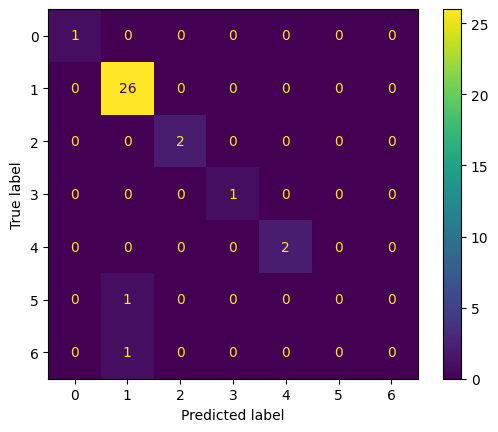

In [140]:
matrix = confusion_matrix(labels_test, y_pred_best)
ConfusionMatrixDisplay(matrix).plot();
print(classification_report(labels_test, y_pred_best))

In [141]:
y_pred_best = cb.predict(embeddings_train)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        87
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135



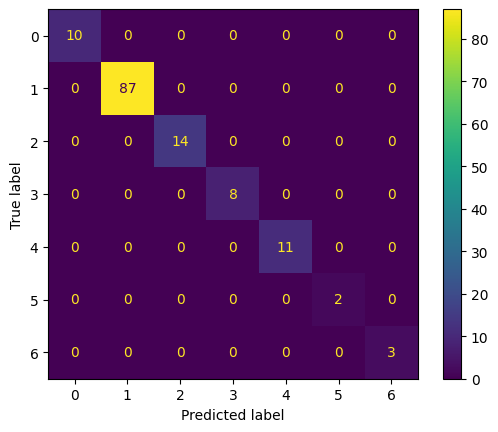

In [142]:
matrix = confusion_matrix(labels_train, y_pred_best)
ConfusionMatrixDisplay(matrix).plot();
print(classification_report(labels_train, y_pred_best))